## Dresslar CAS522 M2 Notebook


In [182]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, MaxNLocator

### Question 1
> Define a python function that generates the adjacency matrix of a random (Erdos-Renyi) graph with N nodes and probability p.

In [183]:
def ER_adj_matrix(N,p):
    """
    Create an adjacency matrix for a random E-R graph with N nodes and probability p.
    For example, if N=3 and p=0.5, we might have:

    [[0, 1, 0],
    [1, 0, 1],
    [0, 1, 0]]

    Note that a tricky aspect is that the matrix is to be symmetric (undirected) and so we need to set one triangle and
    reflect it into the other.
    """
    A = np.zeros((N,N), dtype=int)
    for i in range(N):
        for j in range(i+1, N): # just do the "top" triangle. i+1 includes an offset.
            if np.random.rand() < p:
                A[i,j] = 1
                A[j,i] = 1 # reflection!
                    
    return A

Testing the function:

In [184]:
n = 100 # a very large number here will make things slow.
p = 0.2 # please chose a number between 0 and 1.

A = ER_adj_matrix(n,p)

print(A)

[[0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [1 1 0 ... 0 1 1]
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 1 0 0]]


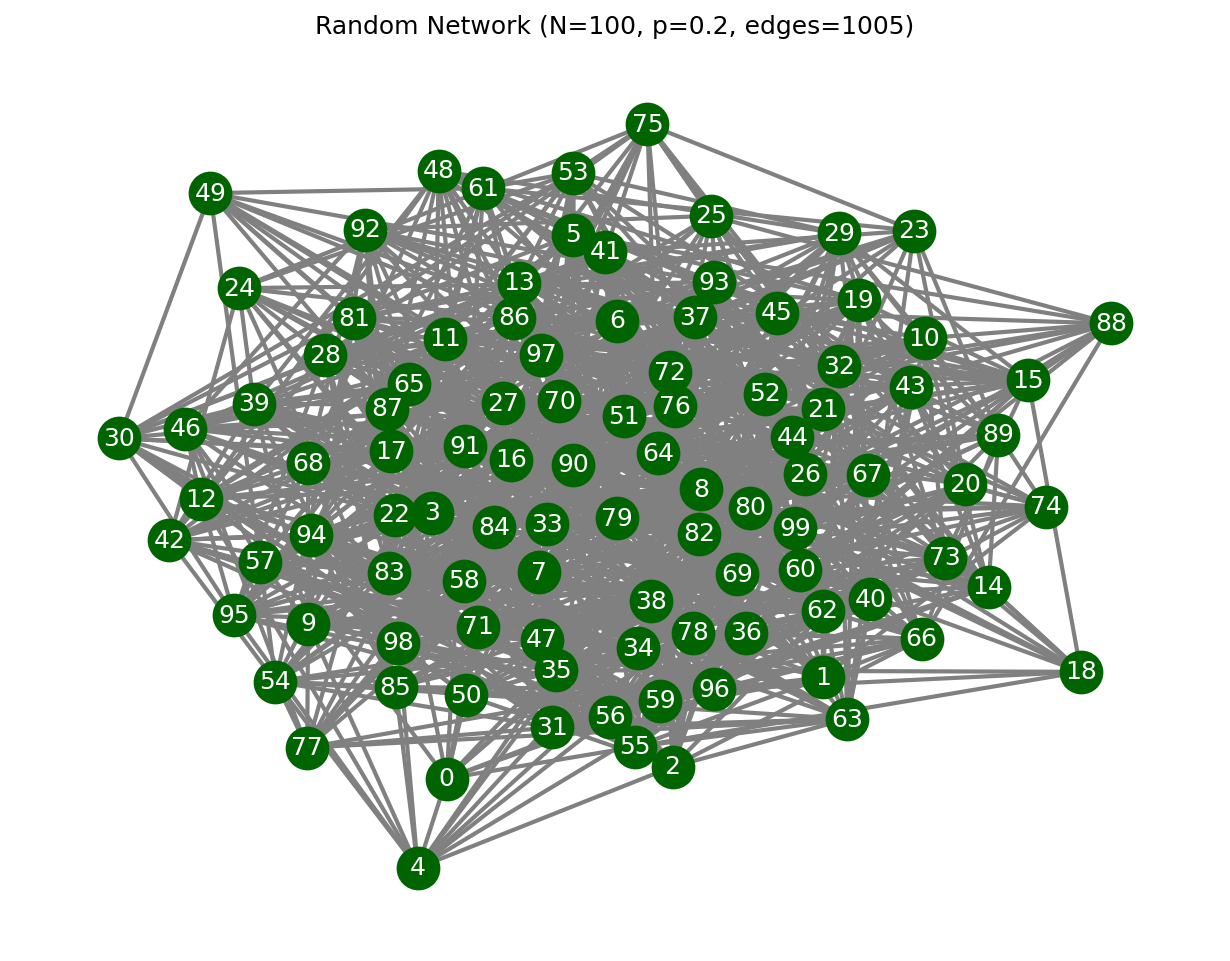

In [185]:
def get_and_plot_network_from_matrix(A):
    # see: https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_numpy_array.html
    G = nx.from_numpy_array(np.array(A))
    
    # layout. see: https://networkx.org/documentation/stable/auto_examples/drawing/plot_spring_layout.html
    pos = nx.spring_layout(G, seed=112358)
    
    # Plot
    plt.figure(figsize=(8, 6), dpi=150)
    nx.draw(G, pos, 
            node_size=400, 
            node_color='darkgreen', 
            edge_color='gray',
            with_labels=True, 
            font_color='white',
            font_size=12,
            width=2)
    plt.title(f"Random Network (N={len(A)}, p={p}, edges={G.number_of_edges()})")
    plt.axis('off')
    plt.show()

    return G

G = get_and_plot_network_from_matrix(A)

### Question 2

> Define a python function that calculates the average clustering coefficient *C* of a random network with adjacency matrix *A* as defined in the previous question. Test your function by changing the inputs *N* and *p*. Can you verify that your function produces the intended results?

In [186]:
# for reference:
print(f"Network A has {A.shape[0]} nodes using probability {p} for edges.")

# here, we can somewhat cheat a bit, since netorkx gives us a function straight out of the box:
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.clustering_coefficient.average_clustering.html
# (Note the E-R graph at the bottom of that document!)

# we still have G from the previous question, so we could use it here:

print(f"Networkx's average clustering coefficient: {nx.average_clustering(G)}")

# we could also have used the nodes in A, and we can try that here: (note that this could get slow for large matrices, as we are not sampling.)

def av_clust_coeff_from_np_matrix(A):
    """
    Calculate the average clustering coefficient of a network from an adjacency matrix.
    """

    # get the number of nodes, or, in other words, the length of the "side" of the matrix
    N = A.shape[0]

    # initialize the average clustering coefficient
    locals = []

    for i in range(N):
        # get the neighbors of node i
        # there is an easier way to do this with np, but...
        neighbors = []
        for j in range(N):
            if A[i,j] == 1:
                neighbors.append(j)

        # get the number of neighbors
        k_sub_i = len(neighbors)

        # now we need to get the number of edges belonging to the neighbors in neighbors
        E_sub_i = 0
        for j in neighbors:
            for k in neighbors:
                if A[j,k] == 1:
                    E_sub_i += 1

        # zero div check
        #### NOTE:
        # Professor Borriello: I don't know if you are seeing my comments, but I do not know for sure from
        # the video whether it is correct to set the following value to 0 (avoiding a zero division). It seems correct, but I am not sure.
        # However, I wonder if this approach is causing the deformation seen in the plot at the bottom of the notebook.

        if k_sub_i < 2: # either 1 or 0 will give us a zero div
            locals.append(0)
            continue # and then we just bail.
        
        C_sub_i = E_sub_i / (k_sub_i * (k_sub_i - 1))
        locals.append(C_sub_i)

    C = np.mean(locals)

    return C

# comment the following out for big matrices!!
print(f"Manual average clustering coefficient: {av_clust_coeff_from_np_matrix(A)}")


Network A has 100 nodes using probability 0.2 for edges.
Networkx's average clustering coefficient: 0.20482021417881557
Manual average clustering coefficient: 0.20482021417881557


Hey! They match up pretty closely! That's cool!

It seems a little unfair to have used a library, here, but perhaps a good thing to do next would be to explore a (small!) model space for different values of R and n using our handy `average_clustering` tool.

In [187]:
# define N sweep range and interval
N_min = 10
N_max = 100
N_step = 10

# define p sweep range and interval
p_min = 0.05
p_max = 0.95
p_step = 0.05

def sweep_C(N_min, N_max, N_step, p_min, p_max, p_step):
    # create empty lists to store results (results will be the value C)
    N_list = list(np.arange(N_min, N_max + 1, N_step)) # integer values
    # np.linspace is better for floats, but we don't want to make the user count the number of intevals. instead we calculate
    # using step size and add 1 to include the last value (since linspace is end-exclusive).
    p_steps = int(round((p_max - p_min) / p_step)) # convert interval to steps
    p_list = np.round(np.linspace(p_min, p_max, p_steps), 2) # float values using linspace

    sweep_outputs = [] # this will be a list of tuples (N, p, C)

    for N in N_list:
        # print(f"Processing N: {N}")
        for p in p_list:
            A = ER_adj_matrix(N,p)
            G = nx.from_numpy_array(np.array(A)) # so we can use networkx's average clustering coefficient
            C = nx.average_clustering(G) # sampling may be faster
            tuple = (N, p, C)
            sweep_outputs.append(tuple)

    print(f"Processed {len(sweep_outputs)} tuples.")

    return N_list, p_list, sweep_outputs

N_list, p_list, sweep_outputs = sweep_C(N_min, N_max, N_step, p_min, p_max, p_step)

Processed 180 tuples.


And now we should be able to plot our result in a 3D diagram...

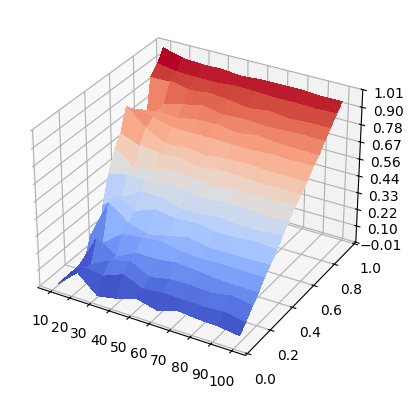

In [ ]:
def plot_C_3D(N_list, p_list, sweep_outputs):
    # 3D plot of C for N vs p
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    # See: https://matplotlib.org/stable/gallery/mplot3d/surface3d.html

    X, Y = np.meshgrid(N_list, p_list, indexing='ij') # steal our lists from the prior cell and mesh them

    # now we need to extract our C values from our tuples
    C_values = [tuple[2] for tuple in sweep_outputs]
    Z = np.array(C_values).reshape(len(N_list), len(p_list)) # a very helpful np function!


    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,    # noqa  --- leaving in the assignment to match the source document
                        linewidth=0, antialiased=False) 
    
    # x axis cleanup: only show integer tick values, and limit the number of ticks to 10
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))

    # z axis cleanup
    ax.set_zlim(-0.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    plt.show()

plot_C_3D(N_list, p_list, sweep_outputs)



We can see that there is more perturbation to the plot where we are working with smaller smaller values of N (smaller graphs). No surprise there. We can zoom in and check again:

Processed 342 tuples.
Processed 342 tuples.


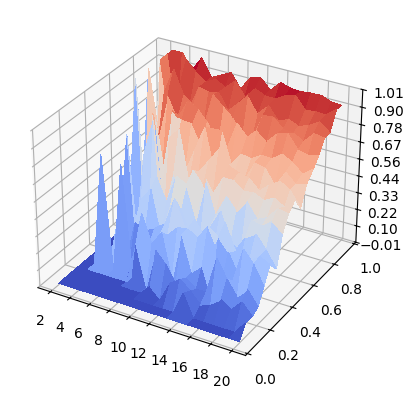

In [189]:
# tighter sweep on N!
tight_N_min = 2
tight_N_max = 20
tight_N_step = 1

tight_N_list, tight_p_list, tight_sweep_outputs = sweep_C(tight_N_min, tight_N_max, tight_N_step, p_min, p_max, p_step)

print(f"Processed {len(tight_sweep_outputs)} tuples.")

plot_C_3D(tight_N_list, tight_p_list, tight_sweep_outputs)




Tight! 

But, this is really super noisy. What if we run our sweeps multiple times and take average values? We'll keep our sweep range the same, but make many runs and average our C outputs into a "super tuple" of results. To do this, we need to slightly update our sweeping function to work well with a sweeps runner.

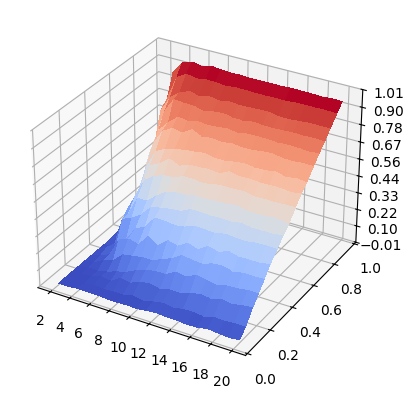

In [190]:

def C_point_tester(N, p):

    A = ER_adj_matrix(N,p)
    G = nx.from_numpy_array(np.array(A)) # so we can use networkx's average clustering coefficient
    C = nx.average_clustering(G) # sampling may be faster

    return C
    

def run_Sweeper(runs, N_list, p_list):
    """
    Runs the sweep_C_runner function for a given number of runs, N_list, and p_list.
    Returns a numpy array with values [N, p, [C]] containing the sweep outputs, for example:
    10, 0.2, [0.0202, 0.0199, 0.0201, ...]
    """
    run_outputs = []
    for N in N_list:
        for p in p_list:
            C_values = []
            for _ in range(runs):
                C_values.append(C_point_tester(N, p))
            run_outputs.append((N, p, C_values))
    return run_outputs

# MAIN RUNNER
# we can set any number of runs here, and the code below will set up the runs and give us summarized output into a plot.
runs = 100

N_list = np.arange(tight_N_min, tight_N_max + 1, tight_N_step)
p_steps = int(round((p_max - p_min) / p_step)) # convert interval to steps
p_list = np.round(np.linspace(p_min, p_max, p_steps), 2)

run_output = run_Sweeper(runs, N_list, p_list) #    10, 0.2, [0.0202, 0.0199, 0.0201, ...]

# now lets summarize the run output using a mean with a simple comprehension
summarized_output = [(N, p, float(np.mean(C_values))) for (N, p, C_values) in run_output]

# summarized_output should now be the format that our plot function expects
plot_C_3D(N_list, p_list, summarized_output)



This looks much cleaner! I think we can oserve that there is some slope deformation at low values, which seems interesting... I do not know the source of this phenomenon, though it is almost imperceptable.